# Video Stream train

In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from datetime import datetime

import tensorflow as tf

# Keras module and tools
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, Dropout
from keras.layers import RandomFlip, CenterCrop, RandomZoom
from keras.metrics import sparse_categorical_accuracy, sparse_top_k_categorical_accuracy
from keras.losses import sparse_categorical_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras_cv.layers import RandomCutout
import keras_tuner

c:\Users\aruna\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6} # to match the audio stream labels
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}

path_frames = "data_frames/"

height_orig = 224
width_orig = 224
width_orig_full = 398
height_targ = 112
width_targ = 112

batch_size = 64
num_classes = len(emotions)

val_actors = ['19', '20']
test_actors = ['21', '22', '23', '24']

## Model 


#### data preparation

In [3]:
#  collecting file paths and labels for training and validation data
filenames_train = [] # train
filenames_val = [] # validation

for (dirpath, dirnames, fn) in os.walk(path_frames):
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion transposition
                filenames_train.append(list(zip(path, label)))
            
            if any(act in dirpath for act in val_actors):                       # select only validation actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)
                filenames_val.append(list(zip(path, label)))

In [4]:
#  function takes a list and a desired number of frames,
#  It performs sampling by randomly selecting num_frames_desired frames from each element in the list. 
#  The sampled frames are then collected into a new list 
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

# function takes a filename as input. It reads the image file using TensorFlow's function,
# decodes the image  with 1 channel (grayscale), converts the image to tf.float16 data type
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

#  function takes a dataset (ds) as input and applies performance optimization configurations to it
def configure_for_performance(ds):
    # shuffles the dataset using a buffer size of 1000
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

# loads and prepares a dataset for training
def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [5]:
# Calling the functions
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
shape frames: (112, 112, 1)
frames number: 46322 
batch size: 64 
batch number: 723


In [6]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 5376 
batch size: 64 
batch number: 84


#### Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    # This layer performs random horizontal flipping of the input images.
    # It randomly flips each image horizontally with a probability of 0.5, resulting in mirrored images.
    RandomFlip("horizontal"),
    
])

#### Example

(112, 112, 1)


(-0.5, 111.5, 111.5, -0.5)

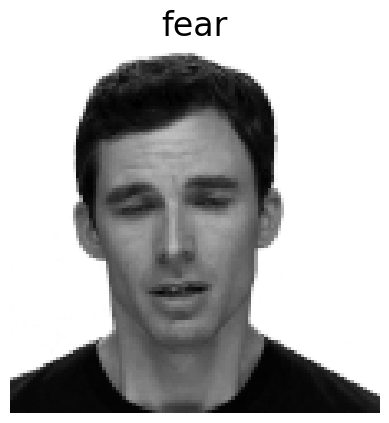

In [8]:
examples = train_ds.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)
plt.imshow(elem[0], cmap='gray')
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')
# plt.savefig('Plots/model3_input.png')


#### Net Architecture

In [74]:
# Change the epochs for more accuracy
epochs = 2
lr = 0.001
momentum = 0.5

 saving the best model weights, reducing the learning rate if necessary, and early stopping based on the validation accuracy during training.

In [75]:
checkpoint_filepath = f'./Models/Video_stream/video_model_{datetime.now().strftime("%d-%m-%y_%H-%M")}_' + '[{val_sparse_categorical_accuracy:.4f}]_face.hdf5'

reduce_lr = ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

The model is a convolutional neural network (CNN) with several convolutional layers followed by max pooling and dropout regularization. It also includes batch normalization and activation functions. The model ends with a dense layer followed by batch normalization, activation, dropout, and a final dense layer with softmax activation for multi-class classification.

In [76]:
input = Input(shape=(width_targ, height_targ, 1))
x = input
x = data_augmentation(x)

x = Conv2D(filters=32, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_0')(x)
x = BatchNormalization(name='batchnorm_0')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_0')(x)

x = Conv2D(filters=64, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_1')(x)
x = BatchNormalization(name='batchnorm_1')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(x)

x = Dropout(0.4, name='dropout_1')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_2')(x)
x = BatchNormalization(name='batchnorm_2')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(x)

x = Dropout(0.4, name='dropout_2')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_3')(x)
x = BatchNormalization(name='batchnorm_3')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(x)

x = Dropout(0.5, name='dropout_3')(x)

x = Flatten(name='flatten')(x)
x = Dense(128, kernel_initializer='he_normal', name='dense_1')(x)
x = BatchNormalization(name='batchnorm_4')(x)
x = Activation('elu')(x)

x = Dropout(0.6, name='dropout_4')(x)

x = Dense(num_classes, activation='softmax', name='out_layer')(x)

output = x

net = Model(inputs=input, outputs=output)
net.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 112, 112, 1)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 112, 112, 1)       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_0 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation_25 (Activation)  (None, 112, 112, 32)      0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                           

In [77]:
net.compile(
        optimizer = Adam(learning_rate=lr),
        loss = sparse_categorical_crossentropy,
        metrics = [sparse_categorical_accuracy],
    )

#### Training

In [ ]:
history = net.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    callbacks=[reduce_lr, early_stop, save_best],
                    verbose=1)

#### Evaluation

In [ ]:
net.evaluate(val_ds,
            batch_size=batch_size,
            steps=step_per_epoch_val)

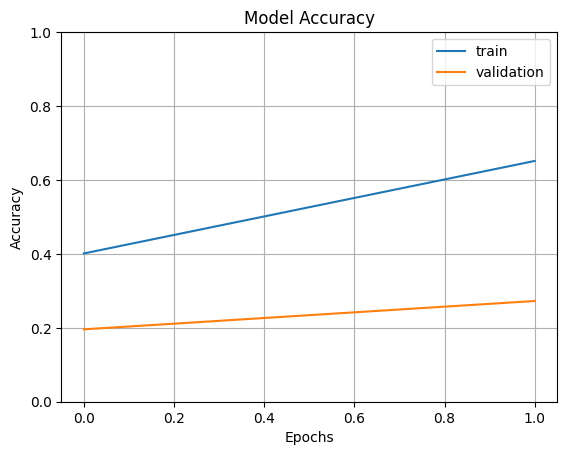

In [80]:
fig1 = plt.gcf()
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [81]:
from sklearn.metrics import classification_report
y_val = []
y_pred = []
i = 1
for image, target in val_ds:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(net(image, training=False).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.19      0.29       768
           1       0.40      0.22      0.28       768
           2       0.26      0.58      0.36       768
           3       0.18      0.63      0.28       768
           4       0.90      0.22      0.35       768
           5       0.84      0.07      0.12       768
           6       0.02      0.00      0.00       768

    accuracy                           0.27      5376
   macro avg       0.46      0.27      0.24      5376
weighted avg       0.46      0.27      0.24      5376

